# Kerasで顔認証

このノートブックではKerasとTensorFlowを使って、顔認証を実装します。

- Face DetectionにはTensorFlowで実装された[MTCNN](https://github.com/ipazc/mtcnn)を使っています
- Face VerificationにはVGGFaceというモデルを使っています
- Kerasで実装されたモデルは[keras-vggface](https://github.com/rcmalli/keras-vggface)を使いました
- パラメータとしてResNetを指定して、トレーニングをしました

[こちら](https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/)のチュートリアルを参考にしました。

### このノートブックの構成

- Face Detection: 生の顔のデータから顔だけを摘出する処理
- Face Verification: 用意した写真に対して、与えられた写真が本人と一致するかを確かめる処理
- TensorFlowで実装する顔認証: Kerasの代わりにTensorFlowで実装する場合の手法について

In [1]:
import tensorflow
import os
from matplotlib import pyplot

## Face Detection

まずは写真データから顔認証ができるように、顔の部分だけ見つけて取り出す作業をします。そこで使うのが、Multi-Task Cascaded Convolutional Neural Network(MTCNN)です。今回使うTensorFlowで実装されたプロジェクトのソースコードは[こちら](https://github.com/ipazc/mtcnn)です。sudo pip install mtcnnでインストールします。

In [2]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.0.9


次に、MTCNNを使って写真から顔を検出する処理を実装します。

In [3]:
# function for face detection with mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	if len(results) == 0:
		print("\nFace is not detected from %s" % (filename))
		formated_original = Image.fromarray(pixels).resize((224, 224))
		imshow(formated_original)
		return asarray(formated_original)
	else:
		x1, y1, width, height = results[0]['box']
		x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

Text(0.5, 1.0, 'Before')

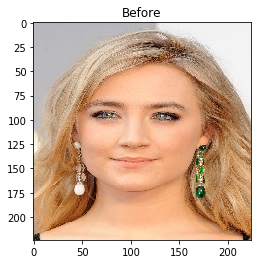

In [4]:
pyplot.imshow(Image.fromarray(pyplot.imread("picutre.jpg")).resize((224,224)))
pyplot.title("Before")

Text(0.5, 1.0, 'After')

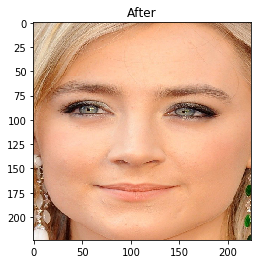

In [5]:
pyplot.imshow(Image.fromarray(extract_face("picutre.jpg")))
pyplot.title("After")

extract_faceを使って顔を検出できることが確認できたので、次は検出されたかをを使って顔認証を実装します。

## Face Verification ##

ここからは前の段階で切り取った写真データを元に、顔固有のベクトルをVGGFaceで計算し、それを比べることで顔が一致するかを確かめる動作を実装します。

まず、Kerasで実装されているVGGFaceをインストールします。このモデルは顔認証のアルゴリズムをResnetかSenetより選べます。ソースコードは[こちら](https://github.com/rcmalli/keras-vggface)です。インストールは、ターミナルで以下のコマンドを入力します。

In [6]:
# example of creating a face embedding
from keras_vggface.vggface import VGGFace

# create a vggface model
model_v = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
print('Inputs: %s' % model_v.inputs)
print('Outputs: %s' % model_v.outputs)

Inputs: [<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>]
Outputs: [<tf.Tensor 'global_average_pooling2d_1/Mean:0' shape=(?, 2048) dtype=float32>]


ここではSharon Stoneという人の顔認証をテストします。

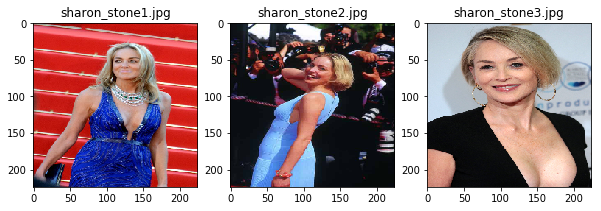

In [8]:
import numpy as np

w=224
h=224
fig=pyplot.figure(figsize=(10, 10))
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    img = Image.fromarray(pyplot.imread("sharon_stone%i.jpg" % (i))).resize((h, w))
    fig.add_subplot(rows, columns, i)
    pyplot.title("sharon_stone%i.jpg"% (i))
    pyplot.imshow(img)
pyplot.show()

上のセルで出力された写真が、今回使うSharon Stoneの写真です。

そして、他人として一致しない写真として使うのが次の写真です。

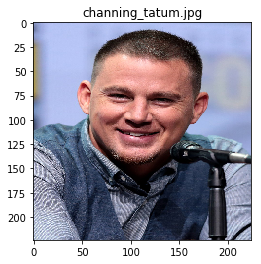

In [9]:
pyplot.imshow(Image.fromarray(pyplot.imread('channing_tatum.jpg')).resize((h, w)))
pyplot.title('channing_tatum.jpg')
pyplot.show()

ここではget_embeddingsで顔固有のベクトルの値を計算し、is_matchではベクトル同士の距離を計算して、顔が一致するかを出力します。

In [10]:
from scipy.spatial.distance import cosine
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
 
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model
	model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
	# perform prediction
	yhat = model.predict(samples)
	return yhat
 
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
 
# define filenames
filenames = ['sharon_stone1.jpg', 'sharon_stone2.jpg',
	'sharon_stone3.jpg', 'channing_tatum.jpg']
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define sharon stone
sharon_id = embeddings[0]
# verify known photos of sharon
print('Positive Tests')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
# verify known photos of other people
print('Negative Tests')
is_match(embeddings[0], embeddings[3])

Positive Tests
>face is a Match (0.418 <= 0.500)
>face is a Match (0.295 <= 0.500)
Negative Tests
>face is NOT a Match (0.709 > 0.500)


ここで、顔認証の処理にどれぐらい時間がかかるかを計算します。

In [17]:
%%timeit -r 1 -n 1
# get embeddings file filenames
embeddings = get_embeddings(filenames[:2])
# define sharon stone
sharon_id = embeddings[0]
# verify known photos of sharon
print('Positive Tests')
is_match(embeddings[0], embeddings[1])

Positive Tests
>face is a Match (0.418 <= 0.500)
20.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


ここではファイルから顔を検出し、顔の認証をする一連の処理に、一回あたりどの程度時間がかかるのかを調べました。

出力された通り、結果は20.4秒でした。

上のセルで出力されているように、最初の二つのテストはsharon stoneの写真を使っているので、顔が一致するはずです。一方で、三つ目のテストでは、男の写真が使われているので、顔は不一致です。

以上がKerasによる顔認証です。写真のファイルを直接呼ぶのではなく、フォルダを作って呼ぶように実装すれば、実際に使えると思います。

# TensorFlowで実装する顔認証

今回はKerasでResnetを実装したものを使いましたが、TensorFlowで実装したものも存在します。[facenet](https://github.com/davidsandberg/facenet)は既に訓練済みの顔認証モデルもあり、これを使えばTensorFlowしか使えないという制限があっても、顔認証システムを構築できるでしょう。

facenetを使うには

- [LFWというデータで検証](https://github.com/davidsandberg/facenet/wiki/Validate-on-lfw)
- [自分で用意した顔の写真に顔認証を試す](https://github.com/davidsandberg/facenet/wiki/Train-a-classifier-on-own-images)

という手順が示されているので、ドキュメントにある通りに進めると自分で用意したデータに対して顔認証をすることができます。

iPhoneやAndroidに組み込むモデルを作成するには、facenetに加えてシェルスクリプトを作成するなどして、顔検出や顔認証を実装していく必要があると考えられます。